## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal profunda


### Estudiantes: 
Angie Chacon - 201012536 
Carolina Padilla - 201111402 
Juan Sebastián Rincón - 201214767 

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas. Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/).   

Identificaremos nuestros mejores modelos según la arquitectura de red, intentando redes multi-capa densamente conectadas y haciendo uso de regularización para el cálculo de su función de pérdida. 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)


Using TensorFlow backend.


## 1. Redes , Validación cruzada doble (DVC) y GD estocástico (SGD)

A continuacion repliquemos el modelo de red sencilla con 5 neuronas que ya construimos paso a paso en clases anteriores. Pero esta vez utilizando la funcion `model`de Keras, que añade capas secuencialmente.

###  Validación cruzada doble (DCV)
Repetimos varias veces el entrenamiento, validación y *prueba* de los modelos con distintas particiones de los datos, implementando una *validación cruzada doble* con el fin de obtener una estimación insesgada del error de predicción (para mayores detalles ver Filmozer et al (2009), http://www.libpls.net/publication/rdCV_2009.pdf) Esta implementación es útil cuando tenemos pocos datos.

### Descenso en la Dirección del Gradiente Estocástico (SGD) 
Para esta primera red sencilla, el proceso de optimización lo vamos a implementar de acuerdo con el método de Descenso en la Dirección del Gradiente Estocástico (SGD). Como ya hemos visto, el método de Descenso en la direccion del gradiente es un método iterativo que permite optimizar funciones objetivo diferenciables, donde 

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial J(\hat \theta_{viejo}; X, Y) }{ \partial \hat \theta_{viejo} }$$ 

siendo $\alpha$ la tasa de aprendizaje y $\theta$ nuestro parámetro a estimar.


La parte estocástica se refiere a que en lugar de utilizar todos los datos en cada paso iterativo, utilizamos una observación (elegida de manera aleatoria) en cada paso. De esta manera, el SGD permite reducir el coste computacional del proceso de optimización, iterando más rápidamente pero con un tasa de convergencia ligeramente menor y más **oscilante**. 

Entonces, el SGD se puede formular de la siguiente manera

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 



Fijémnos que una variación del GD a *medio-camino* del SGD es el GD en *batches* o subconjuntos de datos con un tamaño dado (16, 32, 64,...), el cual optimiza sobre distintos subconjuntos (aleatoriamente seleccionados) del total de los datos en cada iteración.


Además se tienen otras modificaciones sobre el SGD. La más opular es la adición de un término de *momentum*.

### SGD con momentum

Recordando las nociones de física, el término *momentum* hace referencia al algoritmo que avanza a lo largo del espacio paramétrico en búsqueda del óptimo (local), aceleradno de acuerdo con el gradiente de la pérdida (que guardando la anlogía con la física, se refiere a la fuerza). De esta manera, modificando el GD clásico, pues mantiene la misma dirección a medida que avanza disminuyendo las oscilaciones. 

Este método hace parte de la literatura del aprendizaje computacional basado en la *retro-propagación* (Rumelhart et al. (1986) https://www.nature.com/articles/323533a0) 

El SGD con momentum actualiza los estimadores como una combinación lineal entre el gradiente y la actualización previa, implementando un promedio suavizado:


$$ \hat \theta_{nuevo} = \eta \hat \theta_{viejo} - \alpha \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 

donde $\eta$ es el factor de decrecimiento exponencial que toma valores entre 0 y 1. Así, $\eta$ permite incorporar la contribución relativa entre el gradiente actual y de gradientes anteriores. 


A continuación importemos las imagenes:

In [2]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


In [3]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=1_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoca= 672 y accu_v=0.837837815284729
Epoca= 522 y accu_v=0.837837815284729
Epoca= 332 y accu_v=0.7837837934494019
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8158 |  672  |
| 0.9943 | 0.8378 | 0.7895 |  522  |
| 0.9771 | 0.7838 | 0.8421 |  332  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.82; Validacion2: 0.816


Graficamos el desempeño del modelo:

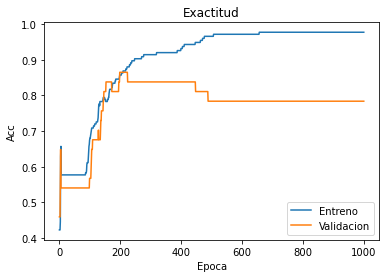

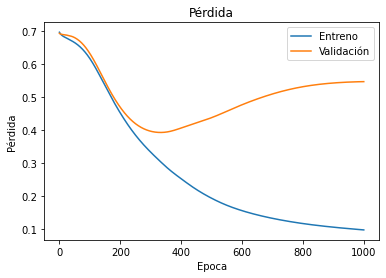

In [4]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Confirmamos que podemos cargar de nuevo el modelo que guardamos:

In [5]:
# red sencilla 5 neuronas
model_1 = load_model('modelo_redsencilla_initseed=1_part_seed=3numn=5.h5')

### Pregunta 1.1

Cuántos parámetros debemos estimar en esta red sencilla?

In [6]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 73505     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 73,511
Trainable params: 73,511
Non-trainable params: 0
_________________________________________________________________


Es posible concluir que el número de parámetros a estimar son 73.511. En la primera capa se estimarán 73.505 dado que las matrices tiene una dimensionalidad de 70 * 70 * 3, y se requiere este numero de wij para cada una de las 5 neuronas, es decir 73.500. Ahora bien, requeriremos del mismo número de sesgos bj que neuronas, para un total de 73.505. Por otro lado necesitamos conectar esto con la capa final de salida, para lo cual se requerirán de 6 parametros. En conclusión se estimarán 73.511 parámetros para esta red.

In [7]:
(70*70*3*5)+5+6

73511

### Replicabilidad

Confirmamos el desempeño del modelo sobre todo el conjunto de datos:_

In [8]:
Y_pred = model_1.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [  9,  96]], dtype=int64)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 140 </td>
       <td> 5 </td>
    </tr>
    <tr>
       <td> 7 </td>
       <td> 98 </td>
    </tr>

</table>

    

### Ejercicio 1.1

Busque un mejor modelo intentando diferentes inicializaciones para la estimación de los parámetros.

### Normal SD(1)

In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []

Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initnorm1 = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm1, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm1, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=2_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 999 y accu_v=0.4324324429035187
Epoca= 999 y accu_v=0.45945945382118225
Epoca= 738 y accu_v=0.6216216087341309
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.6057 | 0.4324 | 0.6053 |  999  |
|  0.6   | 0.4595 | 0.6053 |  999  |
| 0.7486 | 0.6216 | 0.8421 |  738  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.651; Validacion1: 0.505; Validacion2: 0.684


In [10]:
model_2 = load_model('modelo_redsencilla_initseed=2_part_seed=3numn=5.h5')

Y_pred = model_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[145,   0],
       [105,   0]], dtype=int64)

### Zeros

In [11]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []

Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initzeros = keras.initializers.Zeros()

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initzeros, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initzeros, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=3_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 844 y accu_v=0.8108108043670654
Epoca= 440 y accu_v=0.8108108043670654
Epoca= 481 y accu_v=0.8108108043670654
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8108 | 0.8684 |  844  |
| 0.9943 | 0.8108 | 0.7895 |  440  |
| 0.9771 | 0.8108 | 0.7895 |  481  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.811; Validacion2: 0.816


In [12]:
model_3 = load_model('modelo_redsencilla_initseed=3_part_seed=3numn=5.h5')

Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [  8,  97]], dtype=int64)

### Normal Truncada

In [13]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []

Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initnormtr = keras.initializers.TruncatedNormal(mean=0, stddev=0.05, seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnormtr, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnormtr, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=4_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 641 y accu_v=0.7837837934494019
Epoca= 468 y accu_v=0.8108108043670654
Epoca= 350 y accu_v=0.8108108043670654
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.7838 | 0.8158 |  641  |
| 0.9943 | 0.8108 | 0.8158 |  468  |
| 0.9714 | 0.8108 | 0.7895 |  350  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.989; Validacion1: 0.802; Validacion2: 0.807


In [14]:
model_4 = load_model('modelo_redsencilla_initseed=4_part_seed=3numn=5.h5')

Y_pred = model_4.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [ 11,  94]], dtype=int64)

### HE

In [15]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []

Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
inithe = keras.initializers.he_normal(seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=inithe, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=inithe, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=5_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 335 y accu_v=0.7837837934494019
Epoca= 325 y accu_v=0.837837815284729
Epoca= 58 y accu_v=0.5405405163764954
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.7838 | 0.8421 |  335  |
| 0.9943 | 0.8378 | 0.7632 |  325  |
| 0.5771 | 0.5405 | 0.6316 |   58  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.857; Validacion1: 0.721; Validacion2: 0.746


In [16]:
model_5 = load_model('modelo_redsencilla_initseed=5_part_seed=3numn=5.h5')

Y_pred = model_5.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [ 10,  95]], dtype=int64)

### Zeros y Momentum

In [17]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []

Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000
moment=[0.001,0.01,0.1]

# Definimos los parametros del SGD
for m in moment:
    sgd = SGD(lr=0.01, momentum=m)
    # junto con la inicialización aleatoria
    initzm = keras.initializers.Zeros()

    # inicializamos el error para guardar el mejor modelo
    err_p = 999
  
    # implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
    for i in range(0,3,1):
        r = i^3
        CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
        CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
        # Especificamos la arquitectura de la red 
        model = Sequential()  
        model.add(Flatten(input_shape=CE_x.shape[1:]))
        model.add(Dense(5, activation='sigmoid', kernel_initializer=initzm, bias_initializer='zeros'))
        model.add(Dense(1, activation='sigmoid', kernel_initializer=initzm, bias_initializer='zeros')) 
    
        # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
        # Ajustamos el modelo
        history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
        # Encontramos el mejor modelo en validación
        min_err=np.min(history.history['val_loss'])
        best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
        # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
        model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
        # Calculamos las metricas
        train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
        # Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]
    
        if (loss_p < err_p):
            pathr =('modelo_redsencilla_initseed=7_part_seed='+str(r)+'numn=5.h5')
            model.save(pathr) 
            err_p = loss_p
    
        # Imprimimos el desempeño para cada repetición
        print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
        
        x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
        
        # Exactitud media
        Acc_E.append(accu_e)
        Acc_V.append(accu_v)
        Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 844 y accu_v=0.8108108043670654
Epoca= 440 y accu_v=0.8108108043670654
Epoca= 481 y accu_v=0.8108108043670654
Epoca= 841 y accu_v=0.8108108043670654
Epoca= 440 y accu_v=0.8108108043670654
Epoca= 477 y accu_v=0.8108108043670654
Epoca= 822 y accu_v=0.8108108043670654
Epoca= 434 y accu_v=0.8108108043670654
Epoca= 434 y accu_v=0.8108108043670654
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8108 | 0.8684 |  844  |
| 0.9943 | 0.8108 | 0.7895 |  440  |
| 0.9771 | 0.8108 | 0.7895 |  481  |
|  1.0   | 0.8108 | 0.8684 |  841  |
| 0.9943 | 0.8108 | 0.7895 |  440  |
| 0.9771 | 0.8108 | 0.7895 |  477  |
|  1.0   | 0.8108 | 0.8684 |  822  |
| 0.9943 | 0.8108 | 0.7895 |  434  |
| 0.9771 | 0.8108 | 0.8158 |  434  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.811; Validacion2: 0.819


In [18]:
model_7 = load_model('modelo_redsencilla_initseed=7_part_seed=3numn=5.h5')

Y_pred = model_7.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [  8,  97]], dtype=int64)

El modelo que nos brinda una mejora en los resultados, es aquel cuyo método de inicialización se ejecuta con RandomZeros. A su vez, una modificación del mismo RandomZeros, donde se ajusta el valor del parámetro de momento a 0.1, llega a dar resultados similares.

## 2. Redes profundas

Ahora implementemos una red multi-capa, añadiendo más capas al modelo. Primero definimos la técnica de inicialización de He que vimos la clase pasada, la cual está pensada para aliviar el entenamiento de redes profundas con funciones de activación basadas en los rectficadores ReLU.

Recordemos que la inicialización de He para los parametros $W^{[l]}$ consiste en multiplicar sus valores iniciales por  $\sqrt{\frac{2}{n_l}}$.


Ahora, para esta red profunda, vamos a utilizar un método de optimización que nos ayude a reducir el coste computacional que conlleva un número aumentado de parámetros a estimar.

### Propagación de la raiz cuadrada del Cuadrado Medio (RMSProp)

El método de propagación de la raiz cuadrada del cuadrado medio (RMSProp *Root Mean Square Propagation*) permite adaptar la tasa de aprendizaje para cada uno de los parámetros. Esto se hace dividiendo la tasa de aprendizaje (para un parámetro) por un promedio móvil de las magnitudes de los gradientes recientes (ver https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf ) 

De esta manera, un primer promedio movil se calcula en términos de los cuadrados medios del gradiente y el parámetro $\rho$ que representa un factor de memoria a corto plazo sobre los gradientes recientes:

$$ v(\theta) = \rho v(\theta_{viejo}) + (1-\rho) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$


De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \frac{\alpha}{\sqrt{v(\theta)}} \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 

Esta implementación del RMSProp permite adaptar la tasa de aprendizaje sobre la optimización con todos los datos o pequeños subconjuntos de los datos. 


Antes de especificar la estructura de la red, primero definamos la inicializacion de He:

In [19]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

Veamos cómo podemos agregar más capas al modelo que definimos con la ayuda de Keras. A continuación definimos la arquitectura de la red, una con inicializacion aleatoria normal y otra con la incializacion de He:

In [20]:
modeldeep = []

In [21]:
modeldeep.append(Sequential()) 
modeldeep[0].add(Flatten(input_shape=X.shape[1:]))
modeldeep[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modeldeep[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modeldeep[0].add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modeldeep[0].add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modeldeep[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modeldeep[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
#config_norm = model.get_config()

In [22]:
modeldeep.append(Sequential())
modeldeep[1].add(Flatten(input_shape=X.shape[1:]))
modeldeep[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modeldeep[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modeldeep[1].add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modeldeep[1].add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modeldeep[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modeldeep[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
#config_He = model.get_config()

Ahora implementamos el codigo para buscar el mejor modelo con la arquitectura arriba definida, probando ambos métodos de incialización:

Inicio Init=Normal:2020-09-19 18:32:06.511872
Epoca= 179 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 18:35:16.975498


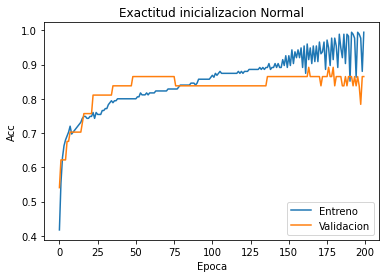

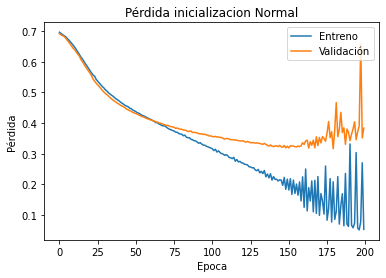

Inicio Init=He:2020-09-19 18:35:17.152539
Epoca= 151 , accu_v1=0.837837815284729 , accu_v2=0.8421052694320679
Fin Init= He:2020-09-19 18:38:16.098983


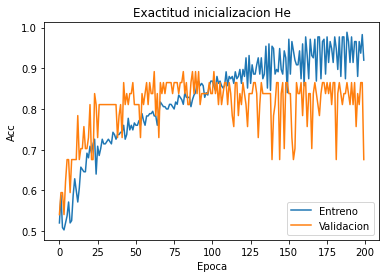

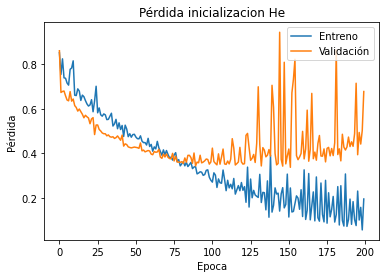

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
|  1.0   | 0.8919 | 0.8421 |  179  | Normal |
|  1.0   | 0.8378 | 0.8421 |  151  |   He   |
+--------+--------+--------+-------+--------+


In [23]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modeldeep[i].compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modeldeep[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modeldeep[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modeldeep[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modeldeep[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modeldeep[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modeldeep[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

### Pregunta 2.1

Qué método de inicialización ayuda más a la convergencia del modelo?

Parece que el método de incialización normal, a diferencia del He, conserva una mejor estabilidad a medida que decrece el valor de pérdida en las gráficas, lo anterior dado que se observan menos picos a medida que aumentan las épocas. Adicionalmente, con base en la gráfica de la función de pérdida, para la base de entrenamiento, la inicialización normal comienza con un valor menor (0.7) y llega igualmente a un valor menor en la época 200 (0.1 apróximadamente), dichos valores también permiten considerar una mejor convergencia en ese modelo. 

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [24]:
# red profunda de 6 capas
modeldeep_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modeldeep_2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_50 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_51 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_52 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_53 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_54 (Dense)             (None, 1)               

In [25]:
Y_pred = modeldeep_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  4, 101]], dtype=int64)

**Salida esperada (aproximada):**
    
<table style="width:20%">
    <tr>
       <td> 139 </td>
       <td> 6 </td>
    </tr>
    <tr>
       <td> 6 </td>
       <td> 99 </td>
    </tr>

</table>

### Ejercicio 2.1

Explore la implementación de regularizacion L1 y L2 sobre la última capa escondida para mejorar el desempeño en validación de la red.



*Ayuda: visite la pagina de Keras https://keras.io/regularizers/
para aplicar regularización sobre la magnitud de los parametros, implemente `kernel_regularizer`
Por ejemplo, si queremos una regularización L2 con una constante de 0.01, escribimos `kernel_regularizer=regularizers.l2(0.01)`


### L1

In [26]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

modelregul = []

modelregul.append(Sequential()) 
modelregul[0].add(Flatten(input_shape=X.shape[1:]))
modelregul[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modelregul[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
modelregul.append(Sequential())
modelregul[1].add(Flatten(input_shape=X.shape[1:]))
modelregul[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modelregul[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1(0.01))) 

Inicio Init=Normal:2020-09-19 18:38:19.891886
Epoca= 179 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 18:41:34.951466


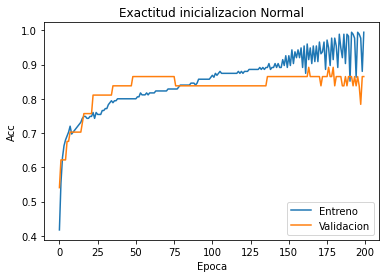

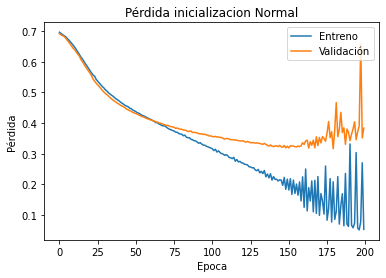

Inicio Init=He:2020-09-19 18:41:35.134508
Epoca= 135 , accu_v1=0.8648648858070374 , accu_v2=0.8421052694320679
Fin Init= He:2020-09-19 18:44:25.704255


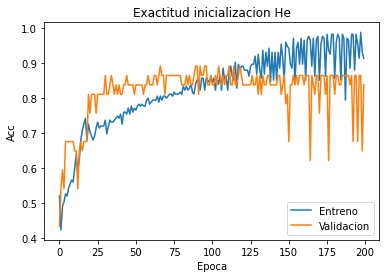

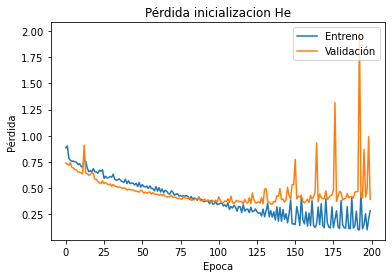

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
|  1.0   | 0.8919 | 0.8421 |  179  | Normal |
|  1.0   | 0.8649 | 0.8421 |  135  |   He   |
+--------+--------+--------+-------+--------+


In [27]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modelregul[i].compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modelregul[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modelregul[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modelregul[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modelregul[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modelregul[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modelregul[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

In [28]:
# red profunda de 6 capas
modelregul_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modelregul_2.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_61 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_62 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_63 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_64 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_65 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_66 (Dense)             (None, 1)               

In [29]:
Y_pred = modelregul_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  4, 101]], dtype=int64)

### L2

In [30]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

modelregul = []

modelregul.append(Sequential()) 
modelregul[0].add(Flatten(input_shape=X.shape[1:]))
modelregul[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modelregul[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
modelregul.append(Sequential())
modelregul[1].add(Flatten(input_shape=X.shape[1:]))
modelregul[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modelregul[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l2(0.01))) 

Inicio Init=Normal:2020-09-19 18:44:29.794387
Epoca= 179 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 18:47:40.857500


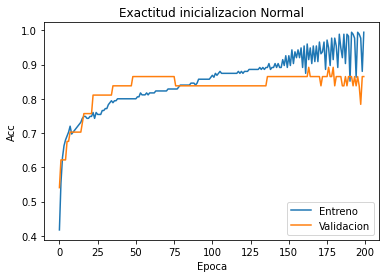

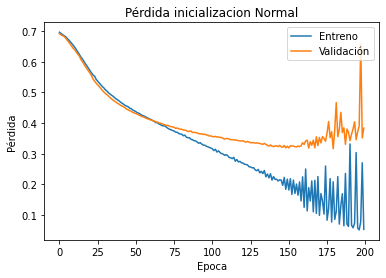

Inicio Init=He:2020-09-19 18:47:41.036541
Epoca= 129 , accu_v1=0.6486486196517944 , accu_v2=0.5
Fin Init= He:2020-09-19 18:50:22.629734


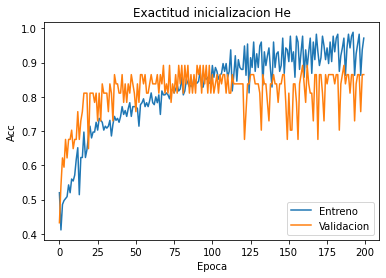

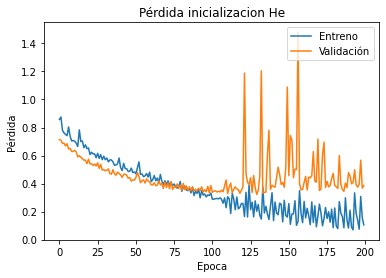

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
|  1.0   | 0.8919 | 0.8421 |  179  | Normal |
| 0.6914 | 0.6486 |  0.5   |  129  |   He   |
+--------+--------+--------+-------+--------+


In [31]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modelregul[i].compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modelregul[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modelregul[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modelregul[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modelregul[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modelregul[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modelregul[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

In [32]:
# red profunda de 6 capas
modelregul_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modelregul_2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_73 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_74 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_75 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_76 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_77 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_78 (Dense)             (None, 1)               

In [33]:
Y_pred = modelregul_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  4, 101]], dtype=int64)

### L1 y L2

In [34]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

modelregul = []

modelregul.append(Sequential()) 
modelregul[0].add(Flatten(input_shape=X.shape[1:]))
modelregul[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modelregul[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
modelregul.append(Sequential())
modelregul[1].add(Flatten(input_shape=X.shape[1:]))
modelregul[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modelregul[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2=0.01))) 

Inicio Init=Normal:2020-09-19 18:50:27.027507
Epoca= 179 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 18:53:35.266681


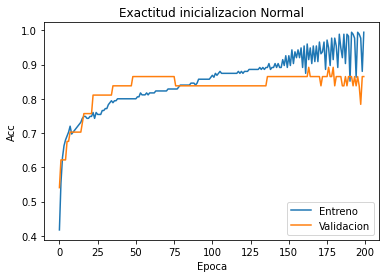

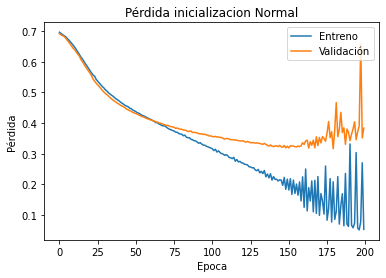

Inicio Init=He:2020-09-19 18:53:35.444722
Epoca= 134 , accu_v1=0.837837815284729 , accu_v2=0.7631579041481018
Fin Init= He:2020-09-19 18:56:19.682829


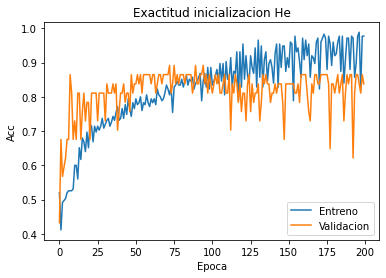

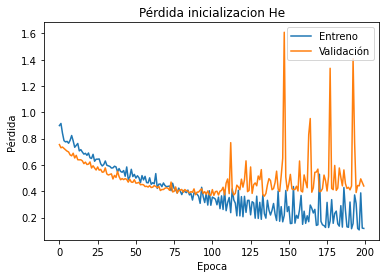

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
|  1.0   | 0.8919 | 0.8421 |  179  | Normal |
| 0.9314 | 0.8378 | 0.7632 |  134  |   He   |
+--------+--------+--------+-------+--------+


In [35]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modelregul[i].compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modelregul[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modelregul[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modelregul[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modelregul[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modelregul[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modelregul[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

In [36]:
# red profunda de 6 capas
modelregul_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modelregul_2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_85 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_86 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_87 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_88 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_89 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_90 (Dense)             (None, 1)               

In [37]:
Y_pred = modelregul_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  4, 101]], dtype=int64)

En nuestro caso, al incluir las diferentes regularizaciones (L1 y L2) el modelo no mejora su desempeño en comparación al planteado en el inciso previo.

## Ejercicio 2.2

Revise los métodos de inicialización, el procedimiento de optimización, la arquitectura de la red y/o las funciones de activación, e intente mejorar los resultados que acabamos de obtener. 

### Función de Activación: Relu, Tanh, Sigmoid | Parámetros: lr = 0.00005, rho = 0.5

In [41]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

modelregul = []

modelregul.append(Sequential()) 
modelregul[0].add(Flatten(input_shape=X.shape[1:]))
modelregul[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modelregul[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(100, activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(50, activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
modelregul.append(Sequential())
modelregul[1].add(Flatten(input_shape=X.shape[1:]))
modelregul[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modelregul[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(100, activation='tanh', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(50, activation='tanh', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2=0.01))) 

Inicio Init=Normal:2020-09-19 18:58:30.247830
Epoca= 184 , accu_v1=0.9189189076423645 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 19:01:40.411320


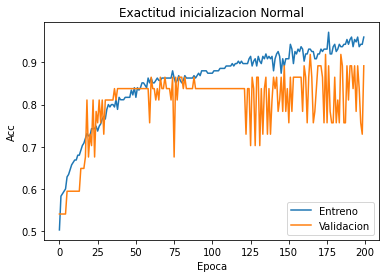

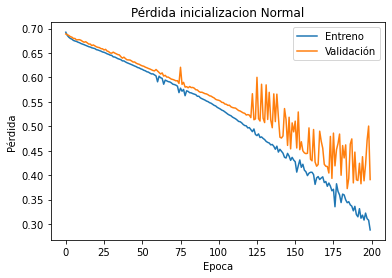

Inicio Init=He:2020-09-19 19:01:40.597362
Epoca= 138 , accu_v1=0.7837837934494019 , accu_v2=0.6052631735801697
Fin Init= He:2020-09-19 19:04:27.645645


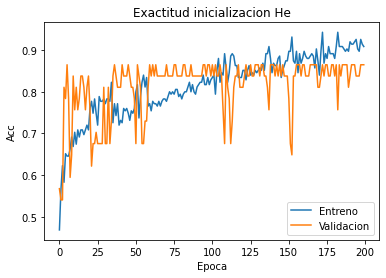

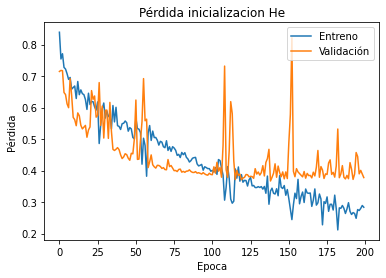

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
| 0.9943 | 0.9189 | 0.8421 |  184  | Normal |
| 0.9143 | 0.7838 | 0.6053 |  138  |   He   |
+--------+--------+--------+-------+--------+


In [42]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00005, rho=0.5)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modelregul[i].compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modelregul[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modelregul[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modelregul[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modelregul[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modelregul[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modelregul[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

In [43]:
# red profunda de 6 capas
modelregul_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modelregul_2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_97 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_98 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_99 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_100 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_101 (Dense)            (None, 15)                765       
_________________________________________________________________
dense_102 (Dense)            (None, 1)               

In [44]:
Y_pred = modelregul_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[138,   7],
       [  3, 102]], dtype=int64)

### Optimización: Adam | Parámetros: lr = 0.001

In [49]:
initHe = keras.initializers.he_normal(seed=1)
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

modelregul = []

modelregul.append(Sequential()) 
modelregul[0].add(Flatten(input_shape=X.shape[1:]))
modelregul[0].add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
modelregul[0].add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
modelregul[0].add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
modelregul.append(Sequential())
modelregul[1].add(Flatten(input_shape=X.shape[1:]))
modelregul[1].add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
modelregul[1].add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
modelregul[1].add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2=0.01))) 

Inicio Init=Normal:2020-09-19 19:12:34.309796
Epoca= 192 , accu_v1=0.837837815284729 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-19 19:16:37.336290


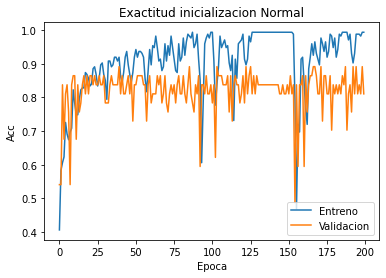

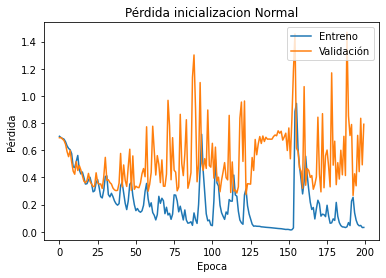

Inicio Init=He:2020-09-19 19:16:37.531332
Epoca= 95 , accu_v1=0.8108108043670654 , accu_v2=0.8421052694320679
Fin Init= He:2020-09-19 19:19:42.973085


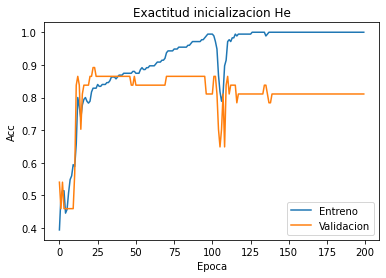

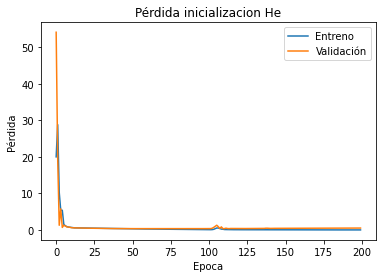

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
|  1.0   | 0.8378 | 0.8421 |  192  | Normal |
|  1.0   | 0.8108 | 0.8421 |   95  |   He   |
+--------+--------+--------+-------+--------+


In [50]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
adam = keras.optimizers.Adam(learning_rate=0.001)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        #model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        #model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    modelregul[i].compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'], )
    
    # Ajustamos el modelo
    history=modelregul[i].fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    modelregul[i].fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = modelregul[i].evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = modelregul[i].evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = modelregul[i].evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    modelregul[i].save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

In [51]:
# red profunda de 6 capas
modelregul_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

modelregul_2.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 14700)             0         
_________________________________________________________________
dense_133 (Dense)            (None, 700)               10290700  
_________________________________________________________________
dense_134 (Dense)            (None, 400)               280400    
_________________________________________________________________
dense_135 (Dense)            (None, 100)               40100     
_________________________________________________________________
dense_136 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_137 (Dense)            (None, 15)                765       
_________________________________________________________________
dense_138 (Dense)            (None, 1)               

In [52]:
Y_pred = modelregul_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  6,  99]], dtype=int64)

Los ajustes en la función de activación, el optimizador y los parámetros parecen no mejorar los resultados; incluso para el caso del optimizador Adam, el modelo presenta una desmejora en su desempeño. Por otro lado, el ajuste a las funciones de activación (adición de tanh), del primer caso, aunque den un número similar en los falsos positivos y negativos, se ve una modificación en su Sensibilidad y en su Especificidad.


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf

## 3. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [ ]:
from keras.preprocessing.image import image

img = image.load_img('IMG_3451.JPG')
img 

### 3.1 Red sencilla

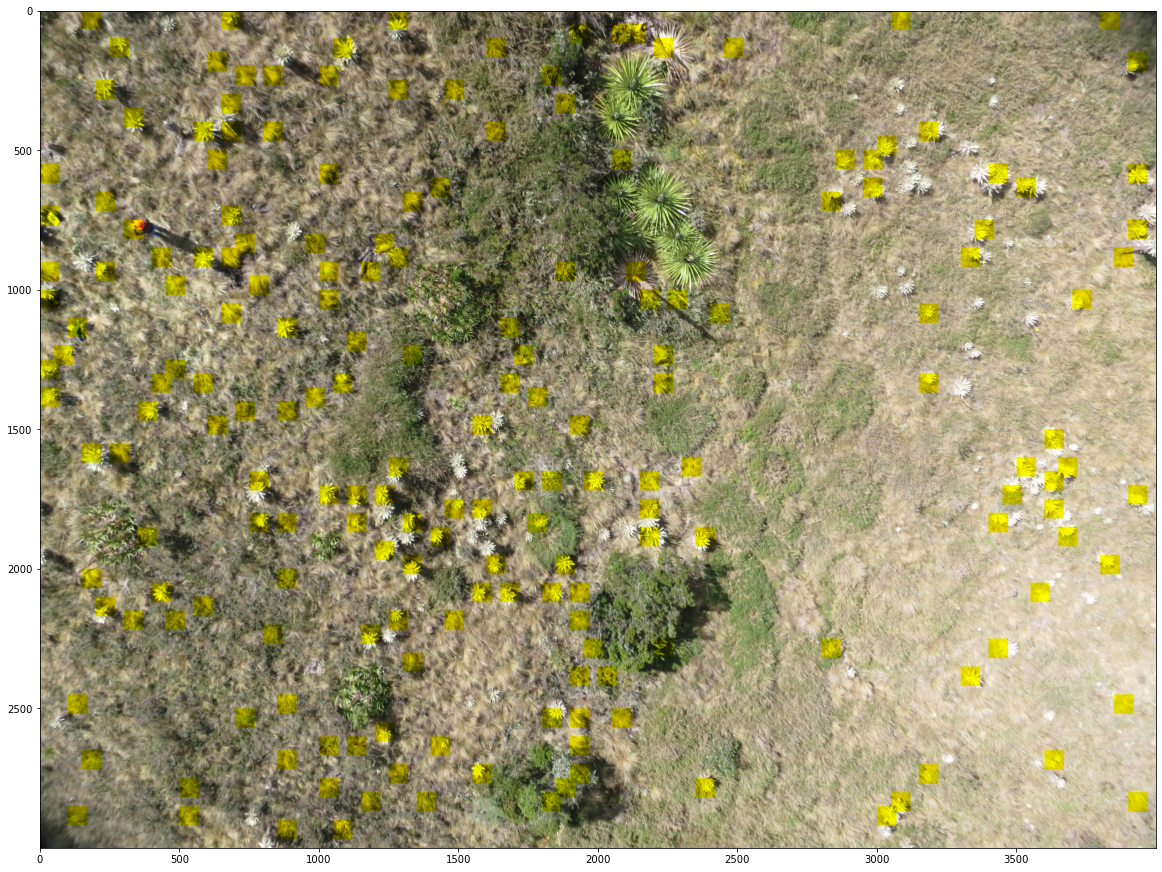

In [54]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_1.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### 3.2 Red multi-capa

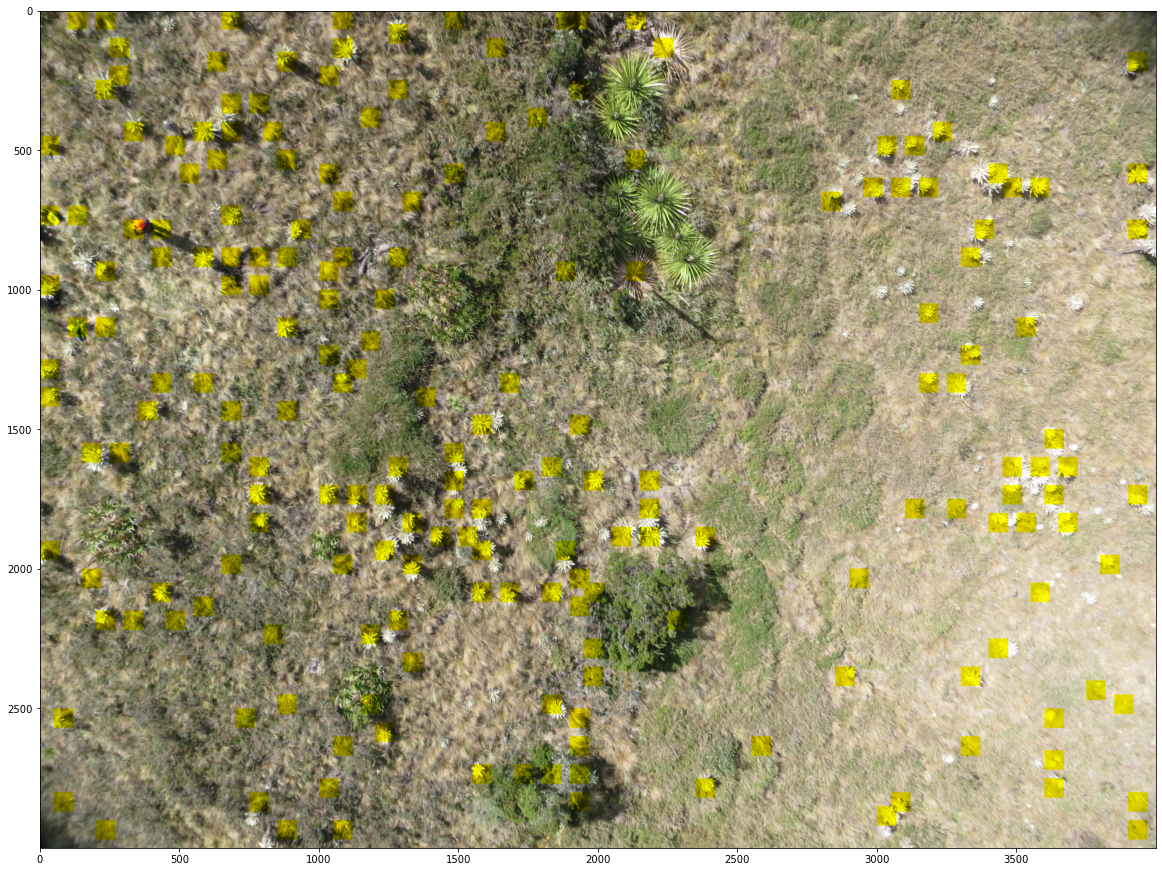

In [56]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = modeldeep_2.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### Pregunta

Qué puede observar sobre el desempeño de los diferentes modelos? Qué estrategias puede proponer para mejorar los modelos?

Es posible observar que la red sencilla tiene una mejor precisión identificando frailejones en espacios con un terreno claro, mientras que la red multicapa parece capturar mejor la información en los terrenos oscuros o con matices similares a los de un frailejon. Como estratégia alterna, podrìa ser posible utilizar redes convolusionales que permitan recopilar la información movilizandose a través de los pixeles, evaluando los diferentes conjuntos de imagenes, para mejorar la precisión. Por otro lado, se podría incrementar la información de entrenamiento, mediante rotaciones de las imagenes actuales, para exponer a la red a una mayor variedad de posibilidades, con el objetivo de que el modelo sea menos propenso a identificar caracteristicas no deseadas. Finalmente, se pueden mejorar características como la calidad y la cantidad de imágenes (frailejones y no frailejones) con las cuales entrenamos el modelo para mejorar su precisión.